### Libraries

In [1]:
import pandas as pd#data structures and operations for manipulating numerical tables and time series.
import pandas_datareader.data as data#Up-to-date remote data access for pandas.
import datetime as dt#supplies classes for manipulating dates and times
from datetime import timedelta
import matplotlib.pyplot as plt#plotting library for the Python.
import seaborn as sns;# visualizacion
import warnings
warnings.filterwarnings('ignore') # We can suppress the warnings
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 
from statsmodels.tsa.stattools import adfuller
import statsmodels.tsa.api as smtsa
import statsmodels.api as sm
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_log_error
from pmdarima import auto_arima
from statsmodels.tsa.ar_model import AR,ARResults# Load specific forecasting tools
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.stattools import arma_order_select_ic
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARMA,ARMAResults,ARIMA,ARIMAResults
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from itertools import product

In [2]:
#!pip install pandas-datareader
#!pip install seaborn
#!conda install -c plotly plotly
#!pip install pmdarima

### Contents

### I.- Describe Data :

This is research about 2 companies of renewable energy in the stock market. The problematic here is a forecasting, that consists of predicting the values in the future of these companies, we are working with time series.


#### A.- EDP Renováveis (EDPR.LS)

In [3]:
# We define the ticket from the companies that we are interested in research.

ticker = ['EDPR.LS']

# We would like all available data from 01-01-2016 until today
start_date = '2016-01-04'

today = dt.date.today()
yesterday = today - timedelta(days=1)
end_date = yesterday

# User pandas_reader.data.DataReader to load the desired data.
EDPR= data.DataReader('EDPR.LS', 'yahoo', start_date, end_date )
EDPR.head()

High    Low   Open  Close    Volume  Adj Close
Date                                                       
2016-01-04  7.267  7.120  7.133  7.267  628745.0   6.967114
2016-01-05  7.344  7.192  7.250  7.240  623709.0   6.941227
2016-01-06  7.250  7.136  7.240  7.238  345564.0   6.939310
2016-01-07  7.240  7.078  7.125  7.233  684252.0   6.934516
2016-01-08  7.299  7.171  7.233  7.194  447045.0   6.897126

In [4]:
EDPR.shape

(1616, 6)

In [5]:
EDPR.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1616 entries, 2016-01-04 to 2022-04-25
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   High       1616 non-null   float64
 1   Low        1616 non-null   float64
 2   Open       1616 non-null   float64
 3   Close      1616 non-null   float64
 4   Volume     1616 non-null   float64
 5   Adj Close  1616 non-null   float64
dtypes: float64(6)
memory usage: 88.4 KB


In [6]:
df_EDPR= EDPR.copy()
# ADD Frecuency information
df_EDPR.index = pd.DatetimeIndex(df_EDPR.index).to_period('D')

df_EDPR.head(2)

High    Low   Open  Close    Volume  Adj Close
Date                                                       
2016-01-04  7.267  7.120  7.133  7.267  628745.0   6.967114
2016-01-05  7.344  7.192  7.250  7.240  623709.0   6.941227

In [7]:
df_EDPR.to_csv("EDPR.csv")# reserve and use in modelling

#### B.- Vestas Wind Systems A/S (VWS.CO)

In [8]:
VWS= data.DataReader('VWS.CO', 'yahoo', start_date, end_date)
VWS.head()

High        Low       Open      Close     Volume  Adj Close
Date                                                                        
2016-01-04  95.959999  94.440002  95.800003  95.040001  5363530.0  87.107880
2016-01-05  95.959999  94.440002  95.800003  95.040001    48610.0  87.107880
2016-01-06  95.360001  92.620003  94.800003  93.940002  4289335.0  86.099678
2016-01-07  92.379997  90.040001  92.000000  91.860001  8454065.0  84.193298
2016-01-08  93.339996  89.800003  91.680000  89.800003  7042265.0  82.305222

In [9]:
VWS.shape

(1578, 6)

In [10]:
VWS.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1578 entries, 2016-01-04 to 2022-04-25
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   High       1578 non-null   float64
 1   Low        1578 non-null   float64
 2   Open       1578 non-null   float64
 3   Close      1578 non-null   float64
 4   Volume     1578 non-null   float64
 5   Adj Close  1578 non-null   float64
dtypes: float64(6)
memory usage: 86.3 KB


In [11]:
df_VWS= VWS.copy()
# ADD Frecuency information
df_VWS.index = pd.DatetimeIndex(df_VWS.index).to_period('D')
df_VWS.head(2)

High        Low       Open      Close     Volume  Adj Close
Date                                                                        
2016-01-04  95.959999  94.440002  95.800003  95.040001  5363530.0   87.10788
2016-01-05  95.959999  94.440002  95.800003  95.040001    48610.0   87.10788

In [12]:
df_VWS.to_csv("VWS.csv")# reserve and use in modelling

### II.- Exploratory Data Analysis (EDA) 

#### A.- EDP Renováveis (EDPR.LS)

In [13]:
EDPR_T= EDPR.describe().transpose()
EDPR_T['Bool Mean'] = EDPR_T['mean'].gt(EDPR_T['50%'])#is the 'mean' greater than the MEDIAN?
#the distribution is positively skewed. 
EDPR_T

count           mean            std          min            25%  \
High       1616.0      11.467444       5.695912      5.75900       7.048500   
Low        1616.0      11.172738       5.455493      5.50000       6.957000   
Open       1616.0      11.317996       5.585547      5.50000       6.993750   
Close      1616.0      11.331017       5.579719      5.70000       7.000000   
Volume     1616.0  482118.551980  854430.937156  21033.00000  150123.500000   
Adj Close  1616.0      11.195229       5.650769      5.50601       6.797747   

                     50%           75%           max  Bool Mean  
High            8.790000      14.52500  2.640000e+01       True  
Low             8.622500      14.20500  2.535000e+01       True  
Open            8.700000      14.46500  2.580000e+01       True  
Close           8.722500      14.42500  2.580000e+01       True  
Volume     303843.000000  602294.25000  2.394718e+07       True  
Adj Close       8.552437      14.36582  2.569415e+01       True

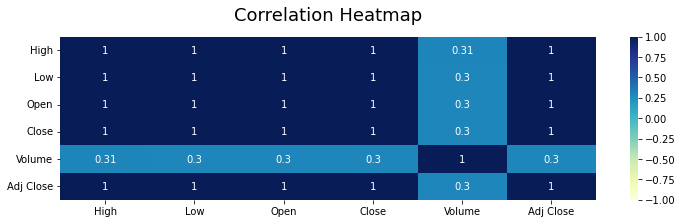

In [14]:
plt.figure(figsize = (12, 3))
heatmap= sns.heatmap(EDPR.corr(),vmin=-1, vmax=1, annot = True, cmap="YlGnBu")
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=16);
plt.show()

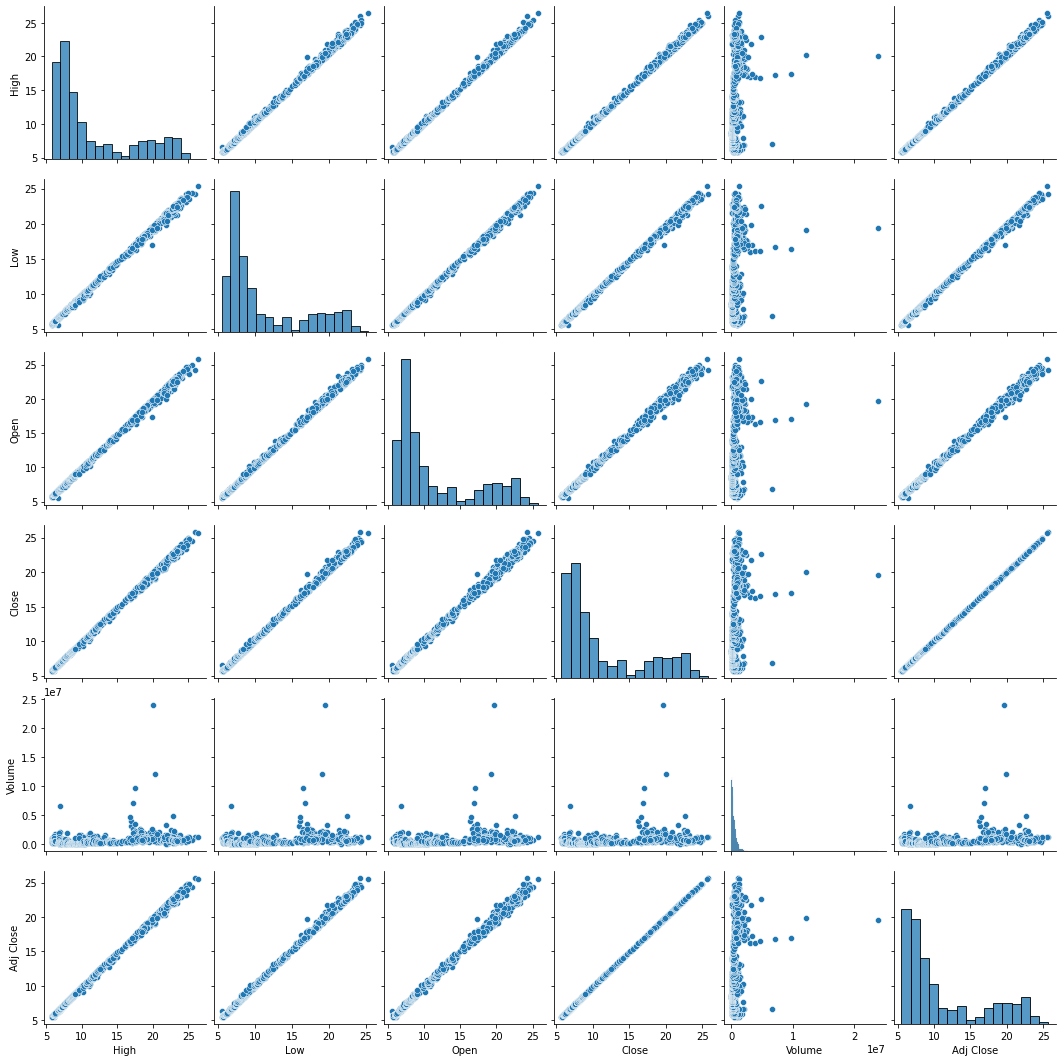

In [15]:
sns.pairplot(EDPR)

<AxesSubplot:>

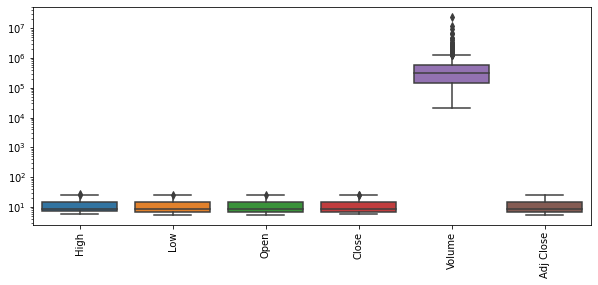

In [16]:
# Initialize the figure with a logarithmic x axis
f, ax = plt.subplots(figsize=(10,4))
ax.set_yscale("log")
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
sns.boxplot(data=EDPR)

In [17]:
# We selected the main column  for us
close_EDPR= EDPR['Close']

# freq='B' stands for only weekdays
weekdays_EDPR= pd.date_range(start=start_date, end=end_date, freq='B')

 # We need reindex close using all weekdays as the new index.
close_EDPR= close_EDPR.reindex(weekdays_EDPR)

#We filling the Missing values (NaN) with 'forward fill'
close_EDPR = close_EDPR.fillna(method='ffill')
close_EDPR = close_EDPR.dropna()# delete NaNs if there are more.
#we passed the information into Dataframe and rename the columns
close_EDPR = pd.DataFrame(close_EDPR).dropna().rename(columns= {0: 'Date', 1: 'Close'})
close_EDPR.head()

Close
2016-01-04  7.267
2016-01-05  7.240
2016-01-06  7.238
2016-01-07  7.233
2016-01-08  7.194

In [18]:
close_EDPR.tail()

Close
2022-04-19  22.799999
2022-04-20  23.010000
2022-04-21  22.770000
2022-04-22  22.570000
2022-04-25  23.000000

In [19]:
close_EDPR.describe()

Close
count  1646.000000
mean     11.322756
std       5.579405
min       5.700000
25%       7.000000
50%       8.722500
75%      14.355000
max      25.799999

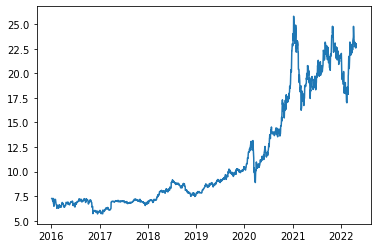

In [20]:
plt.plot(close_EDPR["Close"],label='EDPR Close Price history')

In [21]:
EDPR_df = close_EDPR

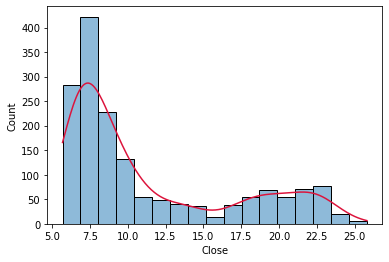

In [22]:
ax= sns.histplot(EDPR_df['Close'], kde=True);
ax.lines[0].set_color('crimson')

In [23]:
EDPR_df.to_csv("EDPR_df.csv")

In [24]:
EDPR_df= pd.read_csv('EDPR_df.csv')#We decided works with a CSV for modeling 
EDPR_df.head()

Unnamed: 0  Close
0  2016-01-04  7.267
1  2016-01-05  7.240
2  2016-01-06  7.238
3  2016-01-07  7.233
4  2016-01-08  7.194

In [25]:
#Renaming column Unnamed: 0
list(EDPR_df.columns)

EDPR_df = EDPR_df.rename(columns={'Unnamed: 0': 'Date'})

In [26]:
EDPR_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1646 entries, 0 to 1645
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    1646 non-null   object 
 1   Close   1646 non-null   float64
dtypes: float64(1), object(1)
memory usage: 25.8+ KB


In [27]:
EDPR_df= EDPR_df[['Date', 'Close']]

In [28]:
#we define date and we reindex the dataframe
EDPR_df.index = EDPR_df["Date"]

In [29]:
EDPR_df= EDPR_df.sort_index(ascending=True,axis=0)
df_1= pd.DataFrame(index=range(0,len(EDPR_df)),columns=['Date','Close'])
for i in range(0,len(df_1)):
    df_1["Close"][i]=EDPR_df["Close"][i]
    df_1["Date"][i]=EDPR_df['Date'][i]

EDPR_df = df_1
#convert  the Date data to datatime Type
EDPR_df["Date"] = pd.to_datetime(EDPR_df.Date, format="%Y/%m/%d")
EDPR_df.head()

Date  Close
0 2016-01-04  7.267
1 2016-01-05   7.24
2 2016-01-06  7.238
3 2016-01-07  7.233
4 2016-01-08  7.194

In [30]:
EDPR_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1646 entries, 0 to 1645
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    1646 non-null   datetime64[ns]
 1   Close   1646 non-null   object        
dtypes: datetime64[ns](1), object(1)
memory usage: 25.8+ KB


#### B.- Vestas Wind Systems A/S (VWS.CO)

In [31]:
VWS_T= VWS.describe().transpose()
VWS_T['Bool Mean'] = VWS_T['mean'].gt(VWS_T['50%'])#is the 'mean' greater than the MEDIAN?
#the distribution is positively skewed. 
VWS_T

count          mean           std           min           25%  \
High       1578.0  1.401430e+02  6.062480e+01     73.279999  9.334500e+01   
Low        1578.0  1.358134e+02  5.777538e+01     71.480003  9.102500e+01   
Open       1578.0  1.380699e+02  5.935815e+01     71.580002  9.221000e+01   
Close      1578.0  1.380317e+02  5.928254e+01     72.160004  9.240000e+01   
Volume     1578.0  4.254832e+06  3.011854e+06  48610.000000  2.599615e+06   
Adj Close  1578.0  1.345204e+02  6.081587e+01     68.264671  8.600829e+01   

                    50%           75%           max  Bool Mean  
High       1.136600e+02  1.865700e+02  3.210000e+02       True  
Low        1.113000e+02  1.810000e+02  3.110000e+02       True  
Open       1.126500e+02  1.843325e+02  3.140000e+02       True  
Close      1.125000e+02  1.838700e+02  3.120000e+02       True  
Volume     3.479660e+06  4.922300e+06  4.817422e+07       True  
Adj Close  1.079686e+02  1.832752e+02  3.093708e+02       True

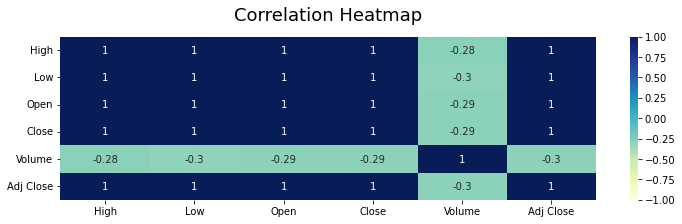

In [32]:
plt.figure(figsize = (12, 3))
heatmap= sns.heatmap(VWS.corr(),vmin=-1, vmax=1, annot = True, cmap="YlGnBu")
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=16);
plt.show()

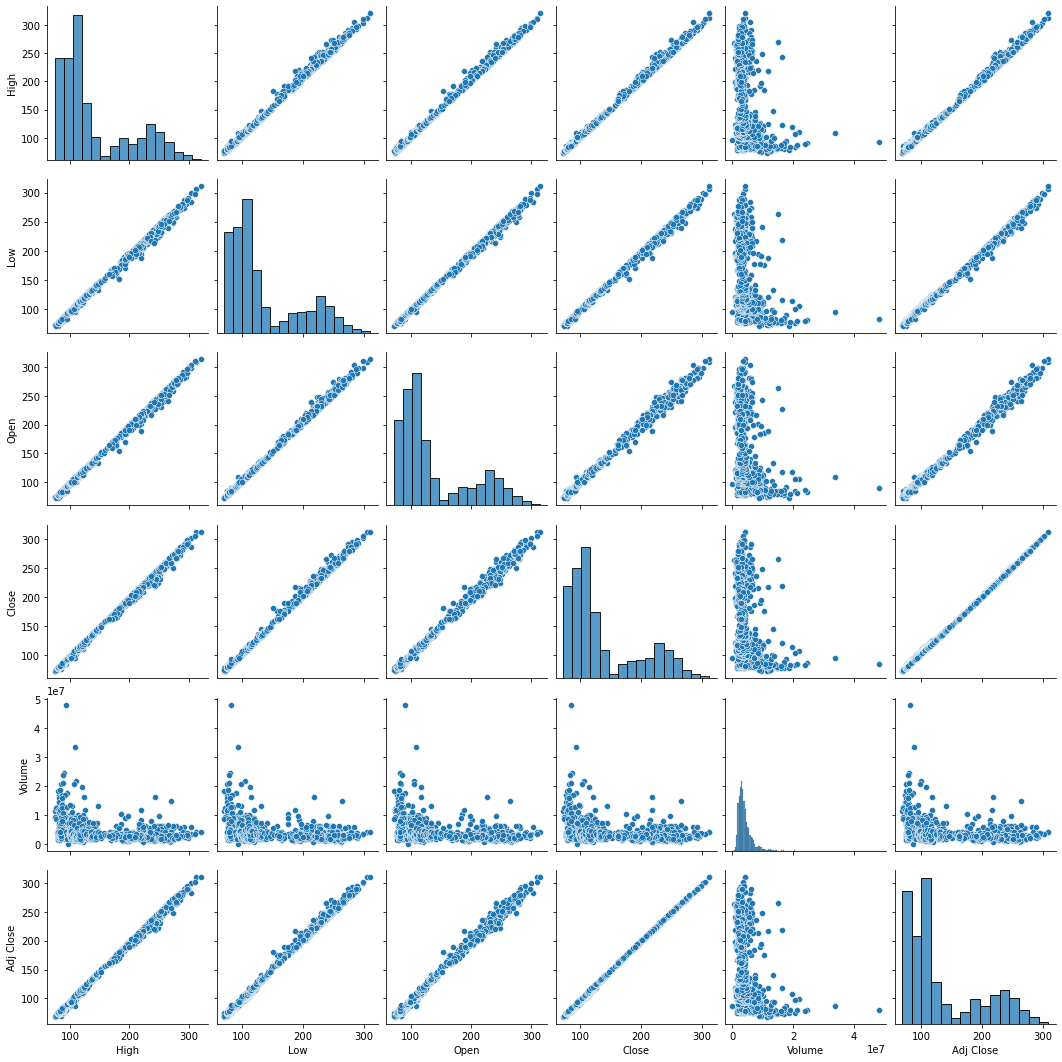

In [33]:
sns.pairplot(VWS)

<AxesSubplot:>

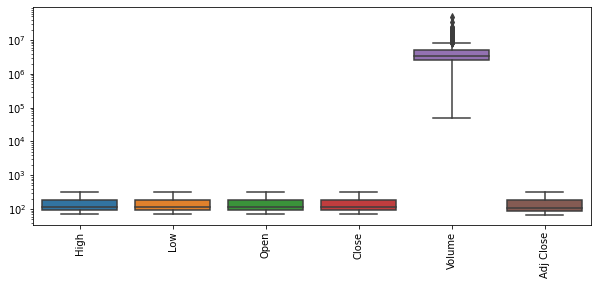

In [34]:
# Initialize the figure with a logarithmic x axis
f, ax = plt.subplots(figsize=(10,4))
ax.set_yscale("log")
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
sns.boxplot(data=VWS)

In [35]:
# We selected the main column  for us
close_VWS= VWS['Close']

# freq='B' stands for only weekdays
weekdays_VWS= pd.date_range(start=start_date, end=end_date, freq='B')

 # We need to align the existing prices, so we reindex close using all weekdays as the new index.
close_VWS= close_VWS.reindex(weekdays_VWS)

#We filling the Missing values (NaN) with 'forward fill'
close_VWS = close_VWS.fillna(method='ffill')
#we passed the information into Dataframe and rename the columns
close_VWS= pd.DataFrame(close_VWS).dropna().rename(columns= {0: 'Date', 1: 'Close'})
close_VWS.head()

Close
2016-01-04  95.040001
2016-01-05  95.040001
2016-01-06  93.940002
2016-01-07  91.860001
2016-01-08  89.800003

In [36]:
close_VWS.tail()

Close
2022-04-19  203.300003
2022-04-20  208.550003
2022-04-21  201.399994
2022-04-22  193.880005
2022-04-25  189.679993

In [37]:
close_VWS.describe()

Close
count  1646.000000
mean    138.053998
std      59.352288
min      72.160004
25%      92.400002
50%     112.800003
75%     183.590004
max     312.000000

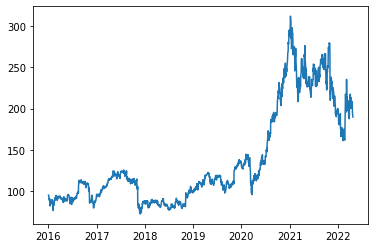

In [38]:
plt.plot(close_VWS["Close"],label='VWS Close Price history')

In [39]:
VWS_df = close_VWS

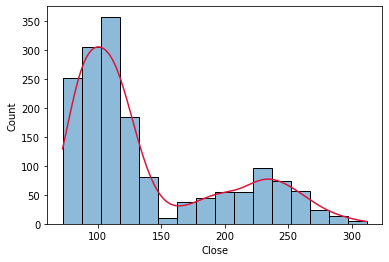

In [40]:
ax= sns.histplot(VWS_df['Close'], kde=True);
ax.lines[0].set_color('crimson')

In [41]:
VWS_df.to_csv("VWS_df.csv")

In [42]:
VWS_df= pd.read_csv('VWS_df.csv')#We decided works with a CSV for modeling 
VWS_df.head()

Unnamed: 0      Close
0  2016-01-04  95.040001
1  2016-01-05  95.040001
2  2016-01-06  93.940002
3  2016-01-07  91.860001
4  2016-01-08  89.800003

In [43]:
#Renaming column Unnamed: 0
list(VWS_df.columns)

VWS_df = VWS_df.rename(columns={'Unnamed: 0': 'Date'})

In [44]:
VWS_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1646 entries, 0 to 1645
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    1646 non-null   object 
 1   Close   1646 non-null   float64
dtypes: float64(1), object(1)
memory usage: 25.8+ KB


In [45]:
VWS_df= VWS_df[['Date', 'Close']]

In [46]:
#we define  the dataframe index value as the data column
VWS_df.index = VWS_df["Date"]

In [47]:
VWS_df= VWS_df.sort_index(ascending=True,axis=0)
df_2 = pd.DataFrame(index=range(0,len(VWS_df)),columns=['Date','Close'])
for i in range(0,len(df_2)):
    df_2["Date"][i]=VWS_df['Date'][i]
    df_2["Close"][i]=VWS_df["Close"][i]

VWS_df = df_2
#convert  the Date data to datatime Type
VWS_df["Date"] = pd.to_datetime(VWS_df.Date, format="%Y/%m/%d")
VWS_df.head()

Date      Close
0 2016-01-04  95.040001
1 2016-01-05  95.040001
2 2016-01-06  93.940002
3 2016-01-07  91.860001
4 2016-01-08  89.800003

In [48]:
VWS_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1646 entries, 0 to 1645
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    1646 non-null   datetime64[ns]
 1   Close   1646 non-null   object        
dtypes: datetime64[ns](1), object(1)
memory usage: 25.8+ KB


In [49]:
VWS_df = VWS_df.rename(columns={'Close': 'VWS'})
Stocks_df = VWS_df

In [50]:
Stocks_df["EDPR"] = EDPR_df["Close"]

In [51]:
Stocks_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1646 entries, 0 to 1645
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    1646 non-null   datetime64[ns]
 1   VWS     1646 non-null   object        
 2   EDPR    1646 non-null   object        
dtypes: datetime64[ns](1), object(2)
memory usage: 38.7+ KB


In [52]:
#we define  the dataframe'd index valu as the data column
Stocks_df.index = Stocks_df["Date"]

In [53]:
Stocks_df= Stocks_df.sort_index(ascending=True,axis=0)
df_3 = pd.DataFrame(index=range(0,len(Stocks_df)),columns=['Date','EDPR', 'VWS'])
for i in range(0,len(df_3)):
    df_3["Date"][i]=Stocks_df['Date'][i]
    df_3["EDPR"][i]=Stocks_df["EDPR"][i]
    df_3["VWS"][i]=Stocks_df["VWS"][i]

Stocks_df = df_3
#convert  the Date data to datatime Type
Stocks_df["Date"] = pd.to_datetime(Stocks_df.Date, format="%Y/%m/%d")
Stocks_df.head()

Date   EDPR        VWS
0 2016-01-04  7.267  95.040001
1 2016-01-05   7.24  95.040001
2 2016-01-06  7.238  93.940002
3 2016-01-07  7.233  91.860001
4 2016-01-08  7.194  89.800003

In [54]:
Stocks_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1646 entries, 0 to 1645
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    1646 non-null   datetime64[ns]
 1   EDPR    1646 non-null   object        
 2   VWS     1646 non-null   object        
dtypes: datetime64[ns](1), object(2)
memory usage: 38.7+ KB


In [55]:
Stocks_df.head()

Date   EDPR        VWS
0 2016-01-04  7.267  95.040001
1 2016-01-05   7.24  95.040001
2 2016-01-06  7.238  93.940002
3 2016-01-07  7.233  91.860001
4 2016-01-08  7.194  89.800003

In [56]:
import plotly.express as px
graphic = px.line(title = 'Stock price history')
for i in Stocks_df.columns[1:]:
  graphic.add_scatter(x = Stocks_df['Date'], y = Stocks_df[i], name = i)
graphic.show()

In [57]:
#Splinting into X/y
X = Stocks_df.drop('Date', axis=1)
y= Stocks_df['Date']
Stocks_normalized = X
Stocks_normalized.head()

EDPR        VWS
0  7.267  95.040001
1   7.24  95.040001
2  7.238  93.940002
3  7.233  91.860001
4  7.194  89.800003

In [58]:
#scaling
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
scaler.fit(Stocks_normalized)
Stocks = scaler.transform(Stocks_normalized)
DF= pd.DataFrame(Stocks)
DF.rename(columns= {0: 'EDPR', 1: 'VWS'}, inplace=True)
X = DF
X['Date'] = y
X.set_index(X.columns[-1], inplace=True)
X.reset_index(inplace=True)
Stock_norm = X

In [59]:
Stock_norm.head()

Date      EDPR       VWS
0 2016-01-04  0.077960  0.095397
1 2016-01-05  0.076617  0.095397
2 2016-01-06  0.076517  0.090811
3 2016-01-07  0.076269  0.082138
4 2016-01-08  0.074328  0.073549

In [60]:
Stock_norm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1646 entries, 0 to 1645
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    1646 non-null   datetime64[ns]
 1   EDPR    1646 non-null   float64       
 2   VWS     1646 non-null   float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 38.7 KB


In [61]:
#Visualizing the graphic with the normalized data

graphic_norm = px.line(title = 'Stock price history')
for i in Stock_norm.columns[1:]:
  graphic_norm.add_scatter(x = Stock_norm['Date'], y = Stock_norm[i], name = i)
graphic_norm.show()

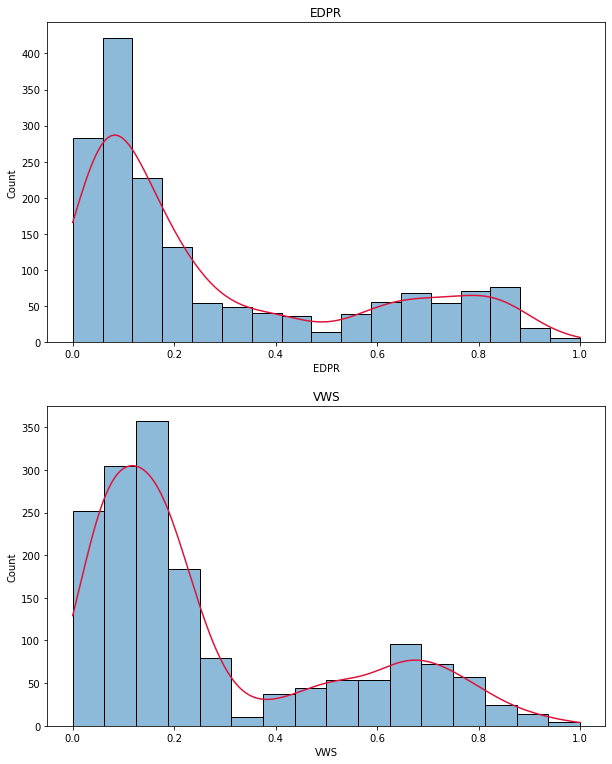

In [62]:
import numpy as np
plt.figure(figsize=(10,20))
i = 1
for i in np.arange(1, len(Stock_norm.columns)):
    plt.subplot(3, 1, i + 1)
    ax=sns.histplot(Stock_norm[Stock_norm.columns[i]], kde = True)
    ax.lines[0].set_color('crimson')
    plt.title(Stock_norm.columns[i])

### II.1- ETS-Decomposition


ETS-Decomposition is a method that allows us to visualize the data after a decomposition of time series into three distinct components: trend, seasonality, and noise.

* Additive decomposition: yt = St + Tt + Rt
* Multiplicative decomposition: yt = St * Tt * Rt

where, 
- S represents the Seasonal variation
- T encodes Trend plus Cycle
- R describes the Residual or the Error component.
Daitan (2019)

In [63]:
# graphs to show seasonal_decompose
def ETS_Decomposition (timeseries):
    decomposition = sm.tsa.seasonal_decompose(timeseries, model='mul',freq=30)
    fig = decomposition.plot()
    fig.set_size_inches(14,7)
    plt.show()

#### A.- EDP Renováveis (EDPR.LS)

In [64]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
EDPR= pd.read_csv('EDPR.csv',index_col='Date',parse_dates=['Date'],date_parser=dateparse, dayfirst=True).fillna(0)#We use the first CSV that we create for modeling
EDPR.asfreq(freq='B')
EDPR.head(2)

High    Low   Open  Close    Volume  Adj Close
Date                                                       
2016-01-04  7.267  7.120  7.133  7.267  628745.0   6.967114
2016-01-05  7.344  7.192  7.250  7.240  623709.0   6.941227

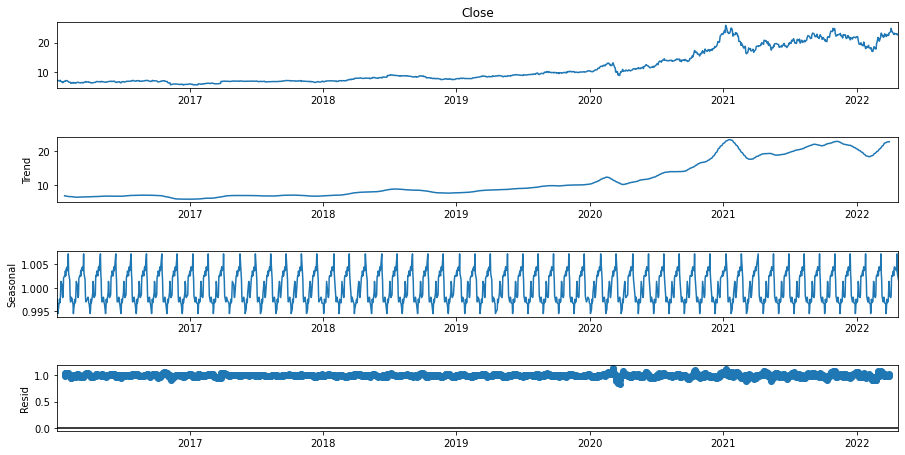

In [65]:
ETS_Decomposition (EDPR['Close'])

#### B.- Vestas Wind Systems A/S (VWS.CO)

In [66]:

VWS= pd.read_csv('VWS.csv',index_col='Date', parse_dates=['Date'],date_parser=dateparse, dayfirst=True).fillna(0)#We use the first CSV that we create for modeling 
VWS.asfreq(freq='b')
VWS.head(2)

High        Low       Open      Close     Volume  Adj Close
Date                                                                        
2016-01-04  95.959999  94.440002  95.800003  95.040001  5363530.0   87.10788
2016-01-05  95.959999  94.440002  95.800003  95.040001    48610.0   87.10788

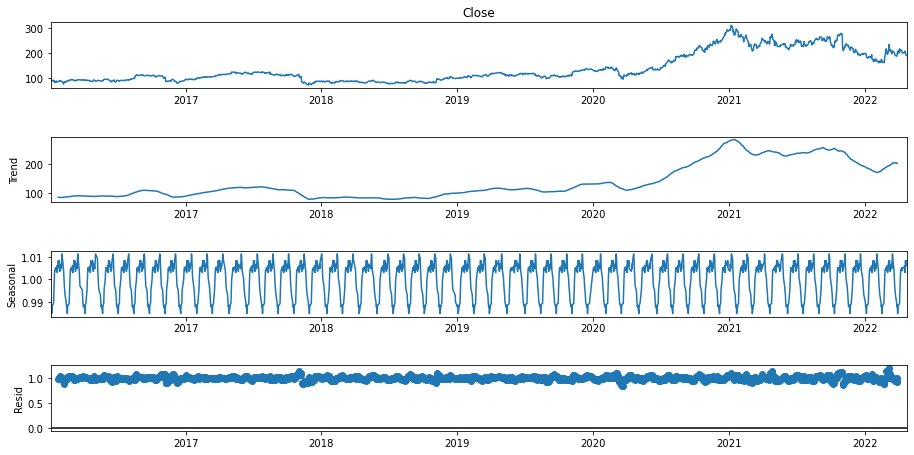

In [67]:
ETS_Decomposition (VWS['Close'])

### II.2.- Augmented Dickey–Fuller test

The Augmented Dickey-Fuller test helps us to detect if a time series is or not “stationary”. Stationary means that the data has no trend, exhibits constant variance over time, and has a constant autocorrelation structure over time. It is ‘stationarize’ the time series as part of the process of fitting a model.Zach (2021) 

In [68]:
def ADFuller(timeseries):
    result = adfuller(timeseries, autolag='AIC')
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t{}: {} - The data is {} stationary with {}% confidence'.format(key, value, 'not' if value < result[0] else '', 100-int(key[:-1])))
        

In [69]:
### Plot for testing Stationarity with mean and standard deviation
def plot_stationarity(timeseries, title):
    
    #Determing rolling statistics
    mean = pd.Series(timeseries).rolling(30).mean()#rolling a month
    std = pd.Series(timeseries).rolling(30).std()#rolling a month
    
    fig, ax = plt.subplots(figsize=(16, 4))
    ax.plot(timeseries, label= title)
    ax.plot(mean, label='rolling mean');
    ax.plot(std, label='rolling std');
    ax.legend()

#### A.- EDP Renováveis (EDPR.LS)

In [70]:
ADFuller(EDPR['Close'])

ADF Statistic: -0.188478
p-value: 0.939881
Critical Values:
	1%: -3.4344694268256246 - The data is not stationary with 99% confidence
	5%: -2.863359483478656 - The data is not stationary with 95% confidence
	10%: -2.5677386582809225 - The data is not stationary with 90% confidence


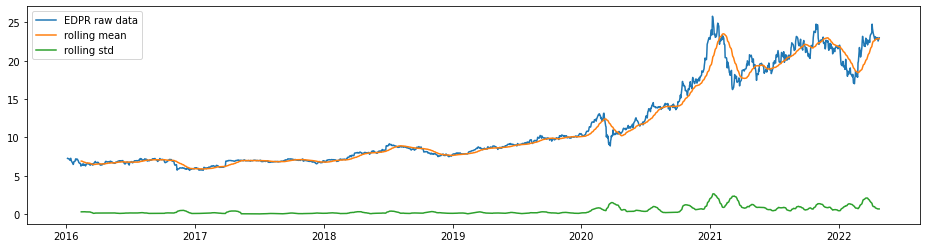

In [71]:
plot_stationarity(EDPR['Close'],'EDPR raw data')

#### B.- Vestas Wind Systems A/S (VWS.CO)

In [72]:
ADFuller(VWS['Close'])

ADF Statistic: -1.139363
p-value: 0.699122
Critical Values:
	1%: -3.434519329789117 - The data is not stationary with 99% confidence
	5%: -2.863381509434791 - The data is not stationary with 95% confidence
	10%: -2.56775038703571 - The data is not stationary with 90% confidence


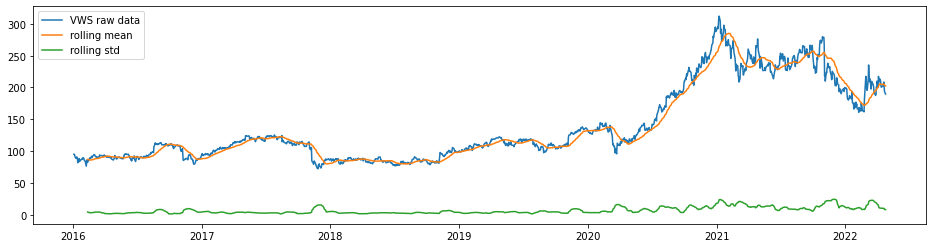

In [73]:
plot_stationarity(VWS['Close'],'VWS raw data')

### II.3.- Make the Data Stationary

### II.3.1.- Detrending: 

- Removing the underlying trend in the time series.

#### A.- EDP Renováveis (EDPR.LS)

ADF Statistic: -6.572093
p-value: 0.000000
Critical Values:
	1%: -3.434516673193861 - The data is  stationary with 99% confidence
	5%: -2.8633803368873942 - The data is  stationary with 95% confidence
	10%: -2.5677497626562813 - The data is  stationary with 90% confidence


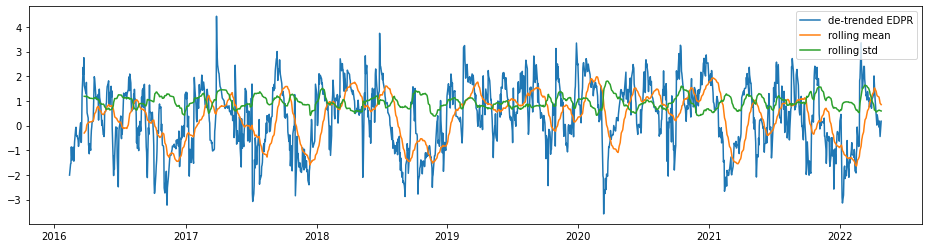

In [74]:
EDPR['Detrend']=  (EDPR['Close'] - EDPR['Close'].rolling(30).mean())/EDPR['Close'].rolling(30).std().dropna()
plot_stationarity(EDPR['Detrend'],'de-trended EDPR')
ADFuller(EDPR['Detrend'].dropna(inplace=False))

#### B.- Vestas Wind Systems A/S (VWS.CO)

ADF Statistic: -7.295154
p-value: 0.000000
Critical Values:
	1%: -3.4345978724183603 - The data is  stationary with 99% confidence
	5%: -2.863416175501975 - The data is  stationary with 95% confidence
	10%: -2.567768846731635 - The data is  stationary with 90% confidence


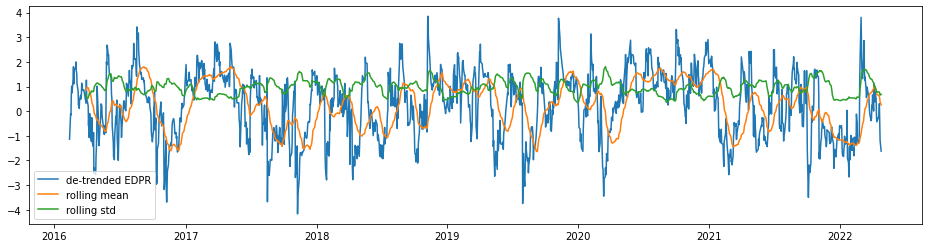

In [75]:
VWS['Detrend'] =  (VWS['Close'] - VWS['Close'].rolling(30).mean())/VWS['Close'].rolling(30).std().dropna()
plot_stationarity(VWS['Detrend'],'de-trended EDPR')
ADFuller(VWS['Detrend'].dropna(inplace=False))

### II.3.2.-  Differencing

#### A.- EDP Renováveis (EDPR.LS)

- Removing the underlying seasonal or cyclical patterns in the time series. 

In [76]:
EDPR['Differencing']=  EDPR['Close'] - EDPR['Close'].shift(1).dropna()

ADF Statistic: -7.744770
p-value: 0.000000
Critical Values:
	1%: -3.4344694268256246 - The data is  stationary with 99% confidence
	5%: -2.863359483478656 - The data is  stationary with 95% confidence
	10%: -2.5677386582809225 - The data is  stationary with 90% confidence


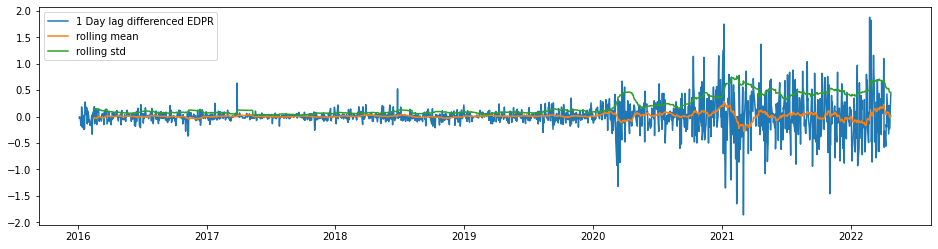

In [77]:
plot_stationarity(EDPR['Differencing'], '1 Day lag differenced EDPR')
ADFuller(EDPR['Differencing'].dropna(inplace=False))

#### B.- Vestas Wind Systems A/S (VWS.CO)

ADF Statistic: -18.271779
p-value: 0.000000
Critical Values:
	1%: -3.434519329789117 - The data is  stationary with 99% confidence
	5%: -2.863381509434791 - The data is  stationary with 95% confidence
	10%: -2.56775038703571 - The data is  stationary with 90% confidence


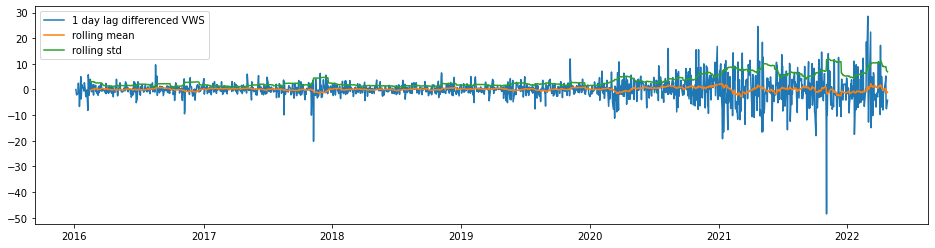

In [78]:
VWS['Differencing'] =  VWS['Close'] - VWS['Close'].shift(1).dropna()

plot_stationarity(VWS['Differencing'], '1 day lag differenced VWS')
ADFuller(VWS['Differencing'].dropna(inplace=False))

### II.3.3.-  Detrending + Differencing

- Removing the underlying trend and the seasonal or cyclical patterns in the time series.

#### A.- EDP Renováveis (EDPR.LS)

ADF Statistic: -11.297505
p-value: 0.000000
Critical Values:
	1%: -3.434543392468286 - The data is  stationary with 99% confidence
	5%: -2.863392129986099 - The data is  stationary with 95% confidence
	10%: -2.567756042468289 - The data is  stationary with 90% confidence


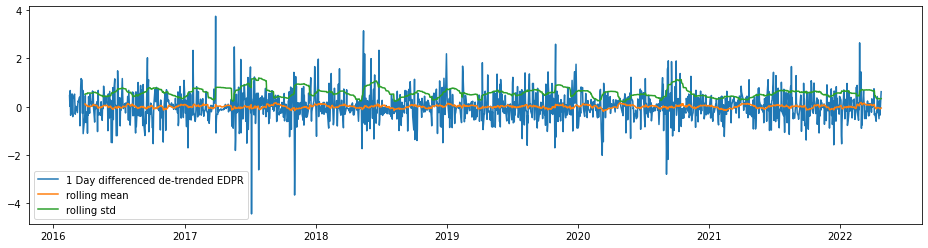

In [79]:
EDPR['Detrend_Diff']=  EDPR['Detrend']- EDPR['Detrend'].shift(1).dropna()
plot_stationarity(EDPR['Detrend_Diff'],'1 Day differenced de-trended EDPR')
ADFuller(EDPR['Detrend_Diff'].dropna(inplace=False))

#### B.- Vestas Wind Systems A/S (VWS.CO)

ADF Statistic: -19.067977
p-value: 0.000000
Critical Values:
	1%: -3.4345978724183603 - The data is  stationary with 99% confidence
	5%: -2.863416175501975 - The data is  stationary with 95% confidence
	10%: -2.567768846731635 - The data is  stationary with 90% confidence


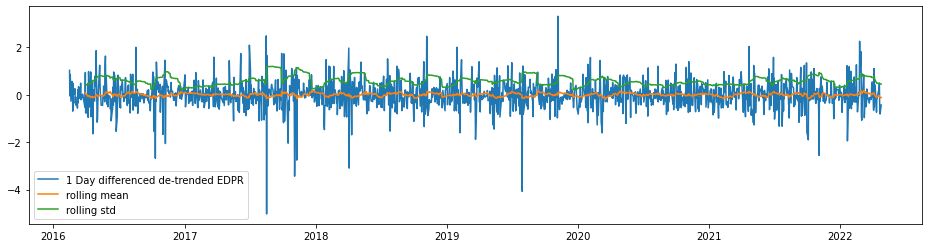

In [80]:
VWS['Detrend_Diff'] =  VWS['Detrend']- VWS['Detrend'].shift(1)

plot_stationarity(VWS['Detrend_Diff'],'1 Day differenced de-trended EDPR')
ADFuller(VWS['Detrend_Diff'].dropna(inplace=False))

### II.4- Identifying AR and MA orders by ACF and PACF plots

Plotting  ACF and PACF help us to undertand how to choose the best MA(q) and AR(p) values:

- ACF= Describes how well the present value of the series is related with its past values 
- PACF= It finds correlation of the residuals

Blue bars on the plots are the error bands, everything in this area is not statistically significant.  In linear regression models performs best when the predictors are not correlated and are independent of each other. 



In [81]:
# plot the data with 30 lags, one Month

### Plot for testing Stationarity with mean and standard deviation
def plot_ACF_PACF(timeseries, title):
    plt.figure(figsize=(12,8))
    layout = (2, 2)
    ax_xt = plt.subplot2grid(layout, (0, 0), colspan = 2)
    ax_acf= plt.subplot2grid(layout, (1, 0))
    ax_pacf = plt.subplot2grid(layout, (1, 1))
    
    timeseries.plot(ax = ax_xt)
    ax_xt.set_title(title)
    plot_acf(timeseries[1:], lags = 50, ax = ax_acf) # first value of diff is NaN
    plot_pacf(timeseries[1:], lags = 50, ax = ax_pacf) # first value of diff is NaN
    plt.tight_layout()

A Q-Q plot is a scatterplot created by plotting two sets of quantiles against one another. If both sets of quantiles came from the same distribution, we should see the points forming a line that’s roughly straight.

In [82]:
# Q-Q plot of the quantiles of x versus the quantiles/ppf of a distribution.
def plot_QQ(timeseries):
    x = sm.qqplot(timeseries, line= 's')

#### A.- EDP Renováveis (EDPR.LS)

ADF Statistic: -11.297505
p-value: 0.000000
Critical Values:
	1%: -3.434543392468286 - The data is  stationary with 99% confidence
	5%: -2.863392129986099 - The data is  stationary with 95% confidence
	10%: -2.567756042468289 - The data is  stationary with 90% confidence


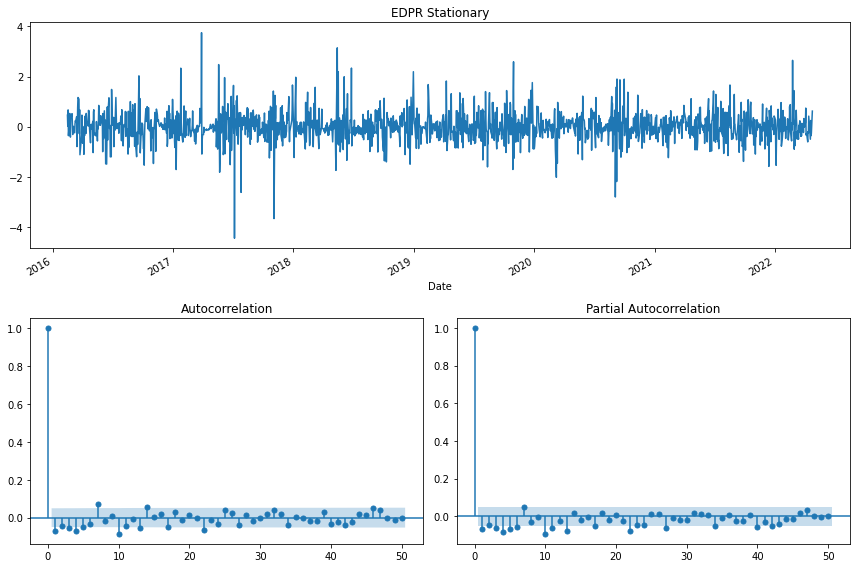

In [83]:
# Drop the first row of 'Close' column because It has 'NaN' value
ADFuller(EDPR['Detrend_Diff'].dropna(inplace=False))
plot_ACF_PACF(EDPR['Detrend_Diff'].dropna(inplace=False) , 'EDPR Stationary')

It looks like the ACF is lagged by 7 and that PACF is geometric. If both ACF and PACF plots demonstrate a gradual decreasing pattern, then the ARMA process should be considered for modelling.

<a href="https://towardsdatascience.com/identifying-ar-and-ma-terms-using-acf-and-pacf-plots-in-time-series-forecasting-ccb9fd073db8">Masum, M. (2020) </a>


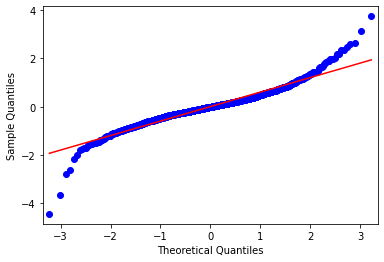

In [84]:
plot_QQ(EDPR['Detrend_Diff'].dropna())

#### B.- Vestas Wind Systems A/S (VWS.CO)

ADF Statistic: -11.297505
p-value: 0.000000
Critical Values:
	1%: -3.434543392468286 - The data is  stationary with 99% confidence
	5%: -2.863392129986099 - The data is  stationary with 95% confidence
	10%: -2.567756042468289 - The data is  stationary with 90% confidence


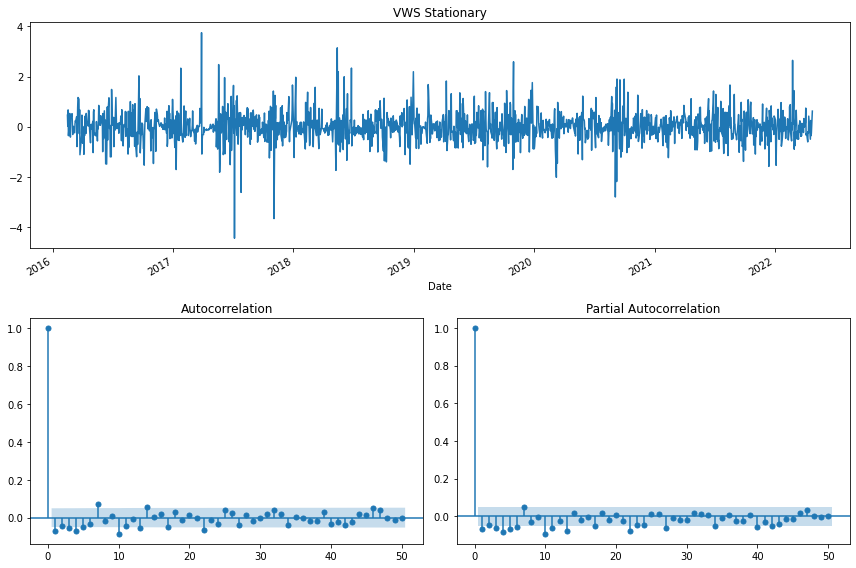

In [85]:
# Drop the first row of 'Close' column because It has 'NaN' value
ADFuller(EDPR['Detrend_Diff'].dropna(inplace=False))
plot_ACF_PACF(EDPR['Detrend_Diff'].dropna(inplace=False) , 'VWS Stationary')

It looks like the ACF is lagged by 7 and that PACF is geometric. If both ACF and PACF plots demonstrate a gradual decreasing pattern, then the ARMA process should be considered for modelling. 
<a href="https://towardsdatascience.com/identifying-ar-and-ma-terms-using-acf-and-pacf-plots-in-time-series-forecasting-ccb9fd073db8">Masum, M. (2020) </a>


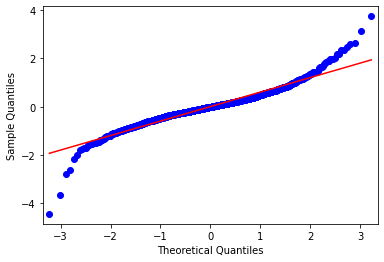

In [86]:
plot_QQ(EDPR['Detrend_Diff'].dropna(inplace=False))

### III. Moving Averages (MA)

-Process where the present value of series is defined as a linear combination of past errors.


#### A.- EDP Renováveis (EDPR.LS)

In [87]:
#create moving average by applying a mean function to a rolling window.
EDPR['SMA1M'] = EDPR['Close'].rolling(window=20).mean()

#EDPR.head()

In [88]:
#create moving average by applying a mean function to a ewm (Exponentially Weighted Moving Average)
EDPR['EWMA1M'] = EDPR['Close'].ewm(span=20,adjust=False).mean()
#EDPR.head()

In [89]:
#create moving average by applying Simple Exponential Smoothing from statmodels Holt-Winters
warnings.filterwarnings('ignore') 
span = 20
alpha = 2/(span+1)
EDPR['SES1M']=SimpleExpSmoothing(EDPR['Close']).fit(smoothing_level=alpha,optimized=False).fittedvalues


In [90]:
#create moving average by applying Double Exponential Smoothing from statmodels Holt-Winters
EDPR['DESadd1M'] = ExponentialSmoothing(EDPR['Close'], trend='add').fit().fittedvalues

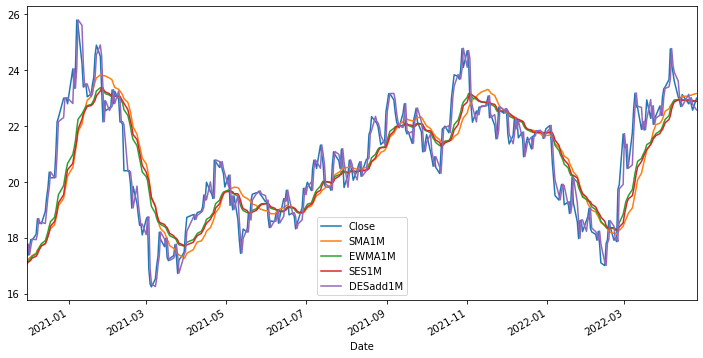

In [91]:
#Plotting the accuracy of the MA
EDPR[['Close','SMA1M','EWMA1M','SES1M','DESadd1M']].iloc[-360:].plot(figsize=(12,6)).autoscale(axis='x',tight=True);

#### B.- Vestas Wind Systems A/S (VWS.CO)

In [92]:
#create moving average by applying a mean function to a rolling window.
VWS['SMA1M'] = VWS['Close'].rolling(window=20).mean()
#VWS.head()

In [93]:
#create moving average by applying a mean function to a ewm (Exponentially Weighted Moving Average)
VWS['EWMA1M'] = VWS['Close'].ewm(span=20,adjust=False).mean()
#VWS.head()

In [94]:
warnings.filterwarnings('ignore') 
#create moving average by applying Simple Exponential Smoothing from statmodels Holt-Winters
span = 20
alpha = 2/(span+1)
VWS.asfreq(freq='b')
VWS['SES1M']=SimpleExpSmoothing(VWS['Close']).fit(smoothing_level=alpha,optimized=False).fittedvalues

In [95]:
#create moving average by applying Double Exponential Smoothing from statmodels Holt-Winters
VWS['DESadd1M'] = ExponentialSmoothing(VWS['Close'], trend='add').fit().fittedvalues

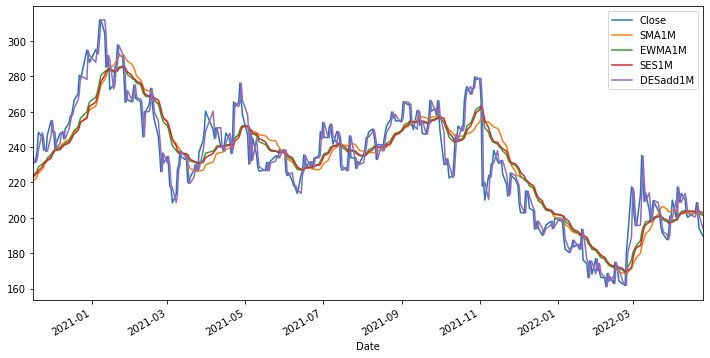

In [96]:
#Plotting the accuracy of the MA
VWS[['Close','SMA1M','EWMA1M','SES1M','DESadd1M']].iloc[-360:].plot(figsize=(12,6)).autoscale(axis='x',tight=True);

### IV.-Modelling


q is number of lagged forecast errors that should go into the ARIMA Model. 
Akaike Information Criteria(AIC) is a  statistical measure to compare different models for their relative quality

In [97]:
def plot_models(timeserie, model, title):
    f, axarr = plt.subplots(1, sharex = True)
    f.set_size_inches(12, 6)
    timeserie.iloc[1:].plot(color = 'b', linestyle = '-', ax = axarr)
    model.iloc[1:].plot(color = 'r', linestyle = '--', ax = axarr)
    axarr.set_title(title)
    plt.legend()
    plt.xlabel('Index')
    plt.ylabel('Closing price')
    

#### IV.1.- Train/Test Splits 

In [98]:
X_A= EDPR.drop(columns= ['Adj Close', 'Close']).values# put the values in an array
y_A= EDPR['Adj Close'].values

In [99]:
X_train_A, X_test_A, y_train_A, y_test_A = train_test_split(X_A, y_A,shuffle=False)

In [100]:
# Divide into train and validation set to calculate R-squared score and mean absolute percentage error 
train_A = EDPR[:int(0.85 * (len(EDPR)))]
test_A  = EDPR[int(0.85 * (len(EDPR))):]
train_A.shape, test_A.shape

((1373, 13), (243, 13))

In [101]:
 #train_A, test_A = X[0:1250], X[1250:len(X)]

In [102]:
X_B= VWS.drop(columns= ['Adj Close', 'Close']).values# put the values in an array
y_B= VWS['Adj Close'].values

In [103]:
X_train_B, X_test_B, y_train_B, y_test_B = train_test_split(X_B, y_B, shuffle=False)

In [104]:
# Divide into train and validation set to calculate R-squared score and mean absolute percentage error 
train_B = VWS[:int(0.85 * (len(VWS)))]
test_B  = VWS[int(0.85 * (len(VWS))):]

train_B.shape, test_B.shape

((1341, 13), (237, 13))

In [105]:
EDPR_Results= pd.DataFrame()
VWS_Results=  pd.DataFrame()
Model= ['ARMA_Whole','ARMA_Split']

https://robjhyndman.com/hyndsight/seasonal-periods/

### IV.1.- ARMA

#### A.- EDP Renováveis (EDPR.LS)

Month: 20 working days

In [106]:
arma_order_select_ic(EDPR['Close'])

{'bic':               0            1            2
 0  10156.039944  8038.789852  6316.612175
 1    426.473369   432.992664   439.274134
 2    432.950892   440.224311   442.429704
 3    439.546391   443.314246   431.301900
 4    438.812746   454.319754   436.706682,
 'bic_min_order': (1, 0)}

In [107]:
arma_EDPR = smtsa.ARMA(EDPR['Close'].tolist(), order=(1, 0)).fit(maxlag=20, method='mle', trend='nc') 


In [108]:
EDPR['ARMA']= arma_EDPR.predict()
arma_EDPR.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                 1616
Model:                     ARMA(1, 0)   Log Likelihood                -203.202
Method:                           mle   S.D. of innovations              0.274
Date:                Tue, 26 Apr 2022   AIC                            410.404
Time:                        21:07:41   BIC                            421.179
Sample:                             0   HQIC                           414.403
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1.y        0.9999      0.000   5360.463      0.000       0.999       1.000
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0001           +0.0000j            1.0001            0.0000
-----------------------------------------------------------------------------
"""

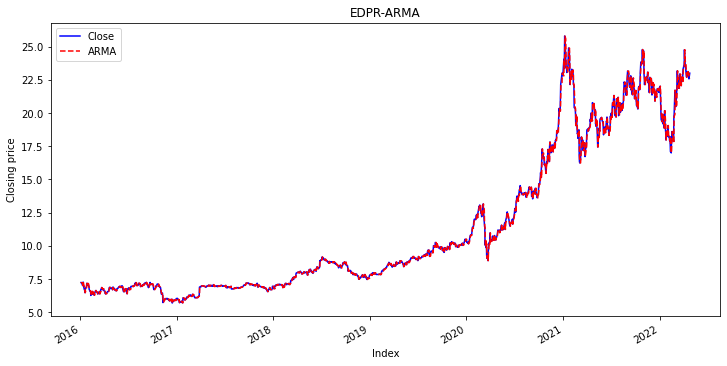

In [109]:
plot_models(EDPR['Close'], EDPR['ARMA'], 'EDPR-ARMA')

##### Validating the Forecast

In [110]:
start = len(train_A)
end   = len(train_A) + len(test_A) - 1
predictions = arma_EDPR.predict(start = start, end = end, dynamic = False, typ = 'levels')

In [111]:
# Create a dataframe to store r2 score
R_arma_EDPR = pd.DataFrame({'r2_score': r2_score(test_A['Close'], predictions)}, index = [0])

# Add columns in the dataframe 'evaluation_results'
R_arma_EDPR['Model'] = 'ARMA'
R_arma_EDPR.set_index(['Model'], inplace=True)
R_arma_EDPR['mean_absolute_error'] = mean_absolute_error(test_A['Close'], predictions)
R_arma_EDPR['mean_squared_error'] = mean_squared_error(test_A['Close'], predictions)
R_arma_EDPR['root_mean_squared_error'] = np.sqrt(mean_squared_error(test_A['Close'], predictions))
R_arma_EDPR['mean_absolute_percentage_error'] = np.mean(np.abs(predictions - test_A['Close'])
                                                               /np.abs(test_A['Close']))*100 
# Display the results
R_arma_EDPR

r2_score  mean_absolute_error  mean_squared_error  \
Model                                                      
ARMA   0.921171             0.372645            0.227365   

       root_mean_squared_error  mean_absolute_percentage_error  
Model                                                           
ARMA                  0.476828                        1.775954

#### B.- Vestas Wind Systems A/S (VWS.CO)

In [112]:
VWS=VWS.dropna()

In [113]:
arma_order_select_ic(VWS['Close'])

{'bic':               0             1             2
 0  17052.712257  15057.006323  13612.190590
 1   8916.728159   8923.749553   8927.815255
 2   8923.722714   8929.822566   8933.201795
 3   8928.293226   8934.401959   8927.429671
 4   8927.813884   8925.192182   8929.834488,
 'bic_min_order': (1, 0)}

In [114]:
arma_VWS = smtsa.ARMA(VWS['Close'].tolist(), order=(1, 0)).fit(maxlag=20, method='mle', trend='nc') 


In [115]:
VWS['ARMA']= arma_VWS.predict()
arma_VWS.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                 1548
Model:                     ARMA(1, 0)   Log Likelihood               -4449.227
Method:                           mle   S.D. of innovations              4.276
Date:                Tue, 26 Apr 2022   AIC                           8902.455
Time:                        21:07:46   BIC                           8913.144
Sample:                             0   HQIC                          8906.431
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1.y        0.9996      0.000   2205.215      0.000       0.999       1.000
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0004           +0.0000j            1.0004            0.0000
-----------------------------------------------------------------------------
"""

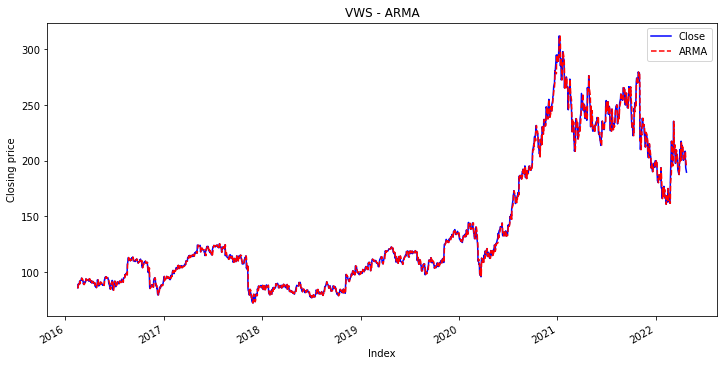

In [116]:
plot_models(VWS['Close'], VWS['ARMA'], 'VWS - ARMA')

##### Validating the Forecast

In [117]:
start = len(train_B)
end   = len(train_B) + len(test_B) - 1
predictions = arma_VWS.predict(start = start, end = end, dynamic = False, typ = 'levels')

In [118]:
# Create a dataframe to store r2 score
R_arma_VWS = pd.DataFrame({'r2_score': r2_score(test_B['Close'], predictions)}, index = [0])

# Add columns in the dataframe 'evaluation_results'
R_arma_VWS['Model'] = 'ARMA'
R_arma_VWS.set_index(['Model'], inplace=True)
R_arma_VWS['mean_absolute_error'] = mean_absolute_error(test_B['Close'], predictions)
R_arma_VWS['mean_squared_error'] = mean_squared_error(test_B['Close'], predictions)
R_arma_VWS['root_mean_squared_error'] = np.sqrt(mean_squared_error(test_B['Close'], predictions))
R_arma_VWS['mean_absolute_percentage_error'] = np.mean(np.abs(predictions - test_B['Close'])
                                                               /np.abs(test_B['Close']))*100 
# Display the results
R_arma_VWS

r2_score  mean_absolute_error  mean_squared_error  \
Model                                                      
ARMA    0.14385             22.56889          736.392963   

       root_mean_squared_error  mean_absolute_percentage_error  
Model                                                           
ARMA                 27.136561                       10.413069

### IV.2.- ARIMA

#### A.- EDP Renováveis (EDPR.LS)

In [119]:
# A nested loop is written to calculate the AIC values
aicVal=[]
for d in range(1,3):
    for ari in range(0, 3):
        for maj in range(0,3):
            try:
                arima_obj = ARIMA(EDPR['Close'].tolist(), order=(ari,d,maj))
                arima_obj_fit=arima_obj.fit()
                aicVal.append([ari, d, maj, arima_obj_fit.aic])
            except ValueError:
                pass
print(aicVal)           

[[0, 1, 0, 400.000834774361], [0, 1, 1, 401.2481880765954], [0, 1, 2, 402.29394308332576], [1, 1, 0, 401.2147142514468], [1, 1, 1, 403.12511805809027], [1, 1, 2, 400.0908583235032], [2, 1, 0, 402.5381070593148], [2, 1, 1, 400.9518083581552], [2, 1, 2, 383.4330615349636], [0, 2, 0, 1482.2902880371691], [0, 2, 1, 408.70497274680656], [0, 2, 2, 409.9657540222761], [1, 2, 0, 1022.1702489775703], [1, 2, 1, 409.9342869264128], [1, 2, 2, 412.6996739381684], [2, 2, 0, 902.3691192336014], [2, 2, 1, 411.27040173822024], [2, 2, 2, 413.8347922024359]]


In [120]:
# Declare and initialise an object 'arima_obj' by calling a method 'ARIMA()'
arima_obj = ARIMA(EDPR['Close'].tolist(), order = (2, 0, 1))#best model by pmdarima.auto_arima
# Train the ARIMA model by calling a method fit()
arima_EDPR= arima_obj.fit(disp = 0)
# Display the summary of the trained model
arima_EDPR.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                 1616
Model:                     ARMA(2, 1)   Log Likelihood                -201.643
Method:                       css-mle   S.D. of innovations              0.274
Date:                Tue, 26 Apr 2022   AIC                            413.286
Time:                        21:07:52   BIC                            440.224
Sample:                             0   HQIC                           423.284
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         13.6203      5.472      2.489      0.013       2.895      24.345
ar.L1.y        1.1530      0.069     16.832      0.000       1.019       1.287
ar.L2.y       -0.1537      0.068     -2.246      0.025      -0.288      -0.020
ma.L1.y       -0.1289      0.073     -1.772      0.076      -0.272       0.014
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0008           +0.0000j            1.0008            0.0000
AR.2            6.4992           +0.0000j            6.4992            0.0000
MA.1            7.7560           +0.0000j            7.7560            0.0000
-----------------------------------------------------------------------------
"""

In [121]:
# Declare the array 'pred' and append the values 
pred = arima_EDPR.fittedvalues.tolist()

In [122]:
# Add a new column 'ARIMA' into dataframe
EDPR['ARIMA'] = pred

In [123]:
# Residues and fitted values are added and stored into dataframe
diffval = arima_EDPR.resid + arima_EDPR.fittedvalues

In [124]:
EDPR['diffval']= diffval

In [125]:
# Display first five records
EDPR.tail()

High        Low       Open      Close     Volume  Adj Close  \
Date                                                                       
2022-04-19  23.10  22.510000  22.940001  22.799999   661543.0  22.799999   
2022-04-20  23.41  22.480000  22.549999  23.010000   587338.0  23.010000   
2022-04-21  23.27  22.629999  22.900000  22.770000   767245.0  22.770000   
2022-04-22  22.90  22.500000  22.639999  22.570000  4896773.0  22.570000   
2022-04-25  23.40  22.379999  22.500000  23.000000   481770.0  23.000000   

             Detrend  Differencing  Detrend_Diff    SMA1M     EWMA1M  \
Date                                                                   
2022-04-19 -0.063091     -0.330000     -0.501484  23.0670  22.926479   
2022-04-20  0.182373      0.210001      0.245464  23.1035  22.934433   
2022-04-21 -0.179323     -0.240000     -0.361696  23.1060  22.918773   
2022-04-22 -0.444734     -0.200001     -0.265411  23.1315  22.885556   
2022-04-25  0.175928      0.430000      0.620662  23.1675  22.896456   

                SES1M   DESadd1M       ARMA      ARIMA    diffval  
Date                                                               
2022-04-19  22.939792  23.139741  23.126749  23.132394  22.799999  
2022-04-20  22.926479  22.809741  22.796796  22.785748  23.010000  
2022-04-21  22.934433  23.019742  23.006767  23.006853  22.770000  
2022-04-22  22.918773  22.779742  22.766801  22.757288  22.570000  
2022-04-25  22.885556  22.579742  22.566828  22.557185  23.000000

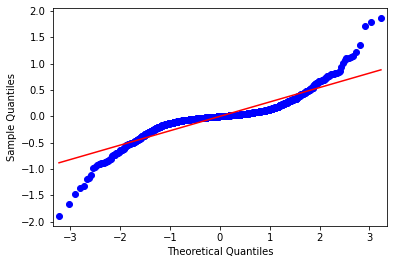

In [126]:
# Q-Q plot of the quantiles of x versus the quantiles/ppf of a distribution.
# Call qqplot() for arima_obj_fit
x = sm.qqplot(arima_obj_fit.resid, line = 's')

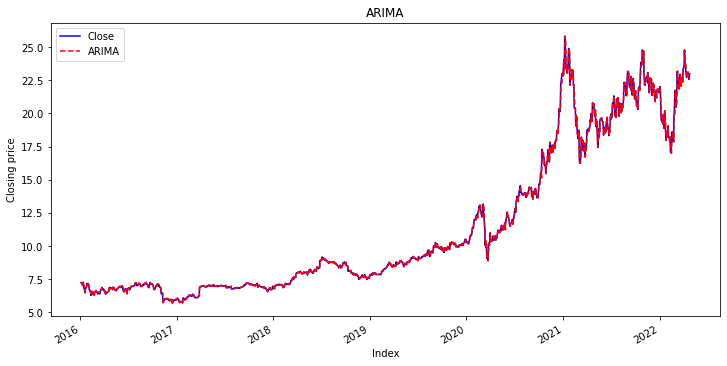

In [127]:
plot_models(EDPR['Close'], EDPR['ARIMA'], 'ARIMA')

Text(0, 0.5, 'Closing')

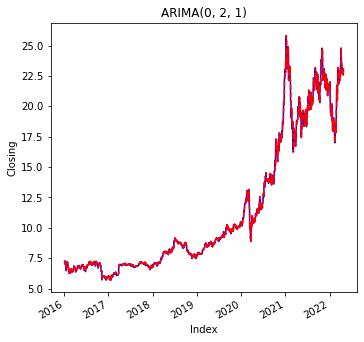

In [128]:
# Declare the objects f and array axarr
f, axarr = plt.subplots(1, sharex = True)
f.set_size_inches(5.5, 5.5)

# Ignore first two rows because of difference factor d = 2
EDPR['diffval'].iloc[2:].plot(color = 'b', linestyle = '-', ax = axarr)
EDPR['ARIMA'].iloc[2:].plot(color = 'r', linestyle = '--', ax = axarr)
axarr.set_title('ARIMA(0, 2, 1)')
plt.xlabel('Index')
plt.ylabel('Closing')

Text(0, 0.5, 'Forecasted value')

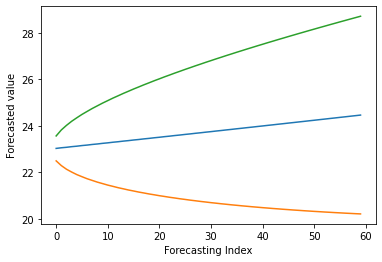

In [129]:
f, err, ci = arima_obj_fit.forecast(60)
plt.plot(f)
plt.plot(ci)
plt.xlabel('Forecasting Index')
plt.ylabel('Forecasted value')
# The forecasting estimates and confidence interval obtained using the preceding script is shown in Figure

##### Validating the Forecast

In [130]:
start = len(train_A)
end   = len(train_A) + len(test_A) - 1
predictions = arima_EDPR.predict(start = start, end = end, dynamic = False, typ = 'levels')

In [131]:
# Create a dataframe to store r2 score
R_arima_EDPR = pd.DataFrame({'r2_score': r2_score(test_A['Close'], predictions)}, index = [0])

# Add columns in the dataframe 'evaluation_results'
R_arima_EDPR ['Model'] = 'ARIMA'
R_arima_EDPR .set_index(['Model'], inplace=True)
R_arima_EDPR ['mean_absolute_error'] = mean_absolute_error(test_A['Close'], predictions)
R_arima_EDPR ['mean_squared_error'] = mean_squared_error(test_A['Close'], predictions)
R_arima_EDPR ['root_mean_squared_error'] = np.sqrt(mean_squared_error(test_A['Close'], predictions))
R_arima_EDPR ['mean_absolute_percentage_error'] = np.mean(np.abs(predictions - test_A['Close'])
                                                               /np.abs(test_A['Close']))*100 
# Display the results
R_arima_EDPR 

r2_score  mean_absolute_error  mean_squared_error  \
Model                                                      
ARIMA  0.921248             0.372361            0.227145   

       root_mean_squared_error  mean_absolute_percentage_error  
Model                                                           
ARIMA                 0.476597                        1.774462

#### B.- Vestas Wind Systems A/S (VWS.CO)

In [132]:
# A nested loop is written to calculate the AIC values
aicVal=[]
for d in range(1,3):
    for ari in range(0, 3):
        for maj in range(0,3):
            try:
                arima_obj = ARIMA(VWS['Close'].tolist(), order=(ari,d,maj))
                arima_obj_fit=arima_obj.fit()
                aicVal.append([ari, d, maj, arima_obj_fit.aic])
            except ValueError:
                pass
print(aicVal)    

[[0, 1, 0, 8889.561984849097], [0, 1, 1, 8891.166969346225], [0, 1, 2, 8890.173411125004], [1, 1, 0, 8891.135642046374], [1, 1, 1, 8891.868910110847], [1, 1, 2, 8890.194226515756], [2, 1, 0, 8890.570249392764], [2, 1, 1, 8891.323415891135], [2, 1, 2, 8878.967897444312], [0, 2, 0, 9981.379340022238], [0, 2, 1, 8894.161820892165], [0, 2, 2, 8895.797695996771], [1, 2, 0, 9476.657031012703], [1, 2, 1, 8895.767913847634], [1, 2, 2, 8897.315660124346], [2, 2, 0, 9361.43634852415], [2, 2, 1, 8895.120194440082], [2, 2, 2, 8895.876428307844]]


In [133]:
# Declare and initialise an object 'arima_obj' by calling a method 'ARIMA()'
arima_obj = ARIMA(VWS['Close'].tolist(), order = (2, 1, 2))#best model by pmdarima.auto_arima
# Train the ARIMA model by calling a method fit()
arima_VWS= arima_obj.fit(disp = 0)
# Display the summary of the trained model
arima_VWS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                 1547
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -4433.484
Method:                       css-mle   S.D. of innovations              4.250
Date:                Tue, 26 Apr 2022   AIC                           8878.968
Time:                        21:07:59   BIC                           8911.032
Sample:                             1   HQIC                          8890.895
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0669      0.111      0.605      0.545      -0.150       0.284
ar.L1.D.y     -0.7857      0.115     -6.825      0.000      -1.011      -0.560
ar.L2.D.y     -0.6901      0.139     -4.948      0.000      -0.964      -0.417
ma.L1.D.y      0.7771      0.098      7.905      0.000       0.584       0.970
ma.L2.D.y      0.7562      0.136      5.578      0.000       0.490       1.022
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -0.5692           -1.0607j            1.2037           -0.3284
AR.2           -0.5692           +1.0607j            1.2037            0.3284
MA.1           -0.5138           -1.0288j            1.1500           -0.3237
MA.2           -0.5138           +1.0288j            1.1500            0.3237
-----------------------------------------------------------------------------
"""

In [134]:
# Declare the array 'pred' and append the values 
pred = np.append([0], arima_VWS.fittedvalues.tolist())

In [135]:
# Add a new column 'ARIMA' into dataframe
VWS['ARIMA'] = pred 

In [136]:
# Residues and fitted values are added and stored into dataframe
diffval = np.append([0],arima_VWS.resid + arima_VWS.fittedvalues)

In [137]:
# Add a column 'diffval' into dataframe
VWS['diffval'] = diffval

In [138]:
# Display first five records
VWS.tail()

High         Low        Open       Close     Volume  \
Date                                                                    
2022-04-19  203.300003  196.199997  201.350006  203.300003  2289636.0   
2022-04-20  210.350006  195.000000  199.000000  208.550003  3396447.0   
2022-04-21  209.600006  201.100006  209.600006  201.399994  2502374.0   
2022-04-22  197.759995  191.800003  197.399994  193.880005  9575889.0   
2022-04-25  198.399994  188.699997  190.000000  189.679993  2912930.0   

             Adj Close   Detrend  Differencing  Detrend_Diff       SMA1M  \
Date                                                                       
2022-04-19  203.300003 -0.172530      2.949997      0.260679  202.392500   
2022-04-20  208.550003  0.309232      5.250000      0.481762  202.400001   
2022-04-21  201.399994 -0.373080     -7.150009     -0.682312  202.265000   
2022-04-22  193.880005 -1.189062     -7.519989     -0.815982  201.859000   
2022-04-25  189.679993 -1.622002     -4.200012     -0.432940  201.585500   

                EWMA1M       SES1M    DESadd1M        ARMA     ARIMA   diffval  
Date                                                                            
2022-04-19  203.550532  203.576903  200.450225  200.267326 -0.672285  2.949997  
2022-04-20  204.026672  203.550532  203.312766  203.216106  1.015638  5.250000  
2022-04-21  203.776512  204.026672  208.521843  208.463939  0.034471 -7.150009  
2022-04-22  202.833988  203.776512  201.583743  201.316881 -0.221299 -7.519989  
2022-04-25  201.581226  202.833988  194.073708  193.799995 -0.096332 -4.200012

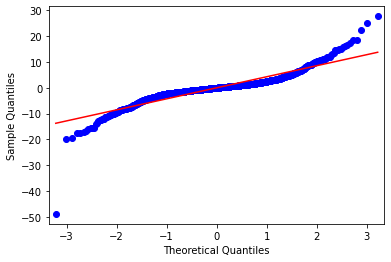

In [139]:
# Q-Q plot of the quantiles of x versus the quantiles/ppf of a distribution.
# Call qqplot() for arima_obj_fit
x = sm.qqplot(arima_obj_fit.resid, line = 's')

Text(0, 0.5, 'Closing')

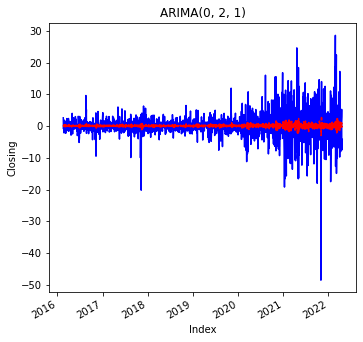

In [140]:
# Declare the objects f and array axarr
f, axarr = plt.subplots(1, sharex = True)
f.set_size_inches(5.5, 5.5)

# Ignore first two rows because of difference factor d = 2
VWS['diffval'].iloc[2:].plot(color = 'b', linestyle = '-', ax = axarr)
VWS['ARIMA'].iloc[2:].plot(color = 'r', linestyle = '--', ax = axarr)
axarr.set_title('ARIMA(0, 2, 1)')
plt.xlabel('Index')
plt.ylabel('Closing')

Text(0, 0.5, 'Forecasted value')

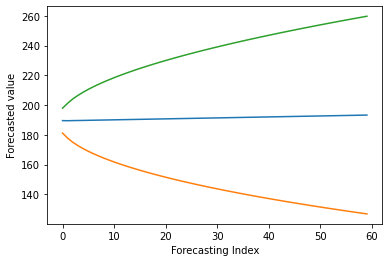

In [141]:
f, err, ci = arima_obj_fit.forecast(60)
plt.plot(f)
plt.plot(ci)
plt.xlabel('Forecasting Index')
plt.ylabel('Forecasted value')
# The forecasting estimates and confidence interval obtained using the preceding script is shown in Figure

##### Validating the Forecast

In [142]:
start = len(train_B)
end   = len(train_B) + len(test_B) - 1
predictions = arima_VWS.predict(start = start, end = end, dynamic = False, typ = 'levels')

In [143]:
# Create a dataframe to store r2 score
R_arima_VWS = pd.DataFrame({'r2_score': r2_score(test_B['Close'], predictions)}, index = [0])

# Add columns in the dataframe 'evaluation_results'
R_arima_VWS['Model'] = 'ARIMA'
R_arima_VWS.set_index(['Model'], inplace=True)
R_arima_VWS['mean_absolute_error'] = mean_absolute_error(test_B['Close'], predictions)
R_arima_VWS['mean_squared_error'] = mean_squared_error(test_B['Close'], predictions)
R_arima_VWS['root_mean_squared_error'] = np.sqrt(mean_squared_error(test_B['Close'], predictions))
R_arima_VWS['mean_absolute_percentage_error'] = np.mean(np.abs(predictions - test_B['Close'])
                                                               /np.abs(test_B['Close']))*100 
# Display the results
R_arima_VWS

r2_score  mean_absolute_error  mean_squared_error  \
Model                                                      
ARIMA  0.150587             22.35508          730.598286   

       root_mean_squared_error  mean_absolute_percentage_error  
Model                                                           
ARIMA                27.029582                       10.309233

### IV.3.-SARIMA

#### A.- EDP Renováveis (EDPR.LS) 

In [144]:
# order = (2, 1, 2) means 
# First 2 for auto regressive model, 1 for difference, and second 2 for moving average
# seasonal_order = (2, 1, 2, 12) means
# 12 additional parameter means number of observations per year or the period
SARIMAX_EDPR = SARIMAX(EDPR['Close'], order = (2, 1, 2), seasonal_order = (2, 1, 2, 12)).fit(dis = -1)

# Display the summary of the model
print(SARIMAX_EDPR.summary())

                                     SARIMAX Results                                      
Dep. Variable:                              Close   No. Observations:                 1616
Model:             SARIMAX(2, 1, 2)x(2, 1, 2, 12)   Log Likelihood                -223.647
Date:                            Tue, 26 Apr 2022   AIC                            465.294
Time:                                    21:08:16   BIC                            513.711
Sample:                                         0   HQIC                           483.271
                                           - 1616                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0186      0.430      0.043      0.966      -0.824       0.861
ar.L2          0.7988      0.433   

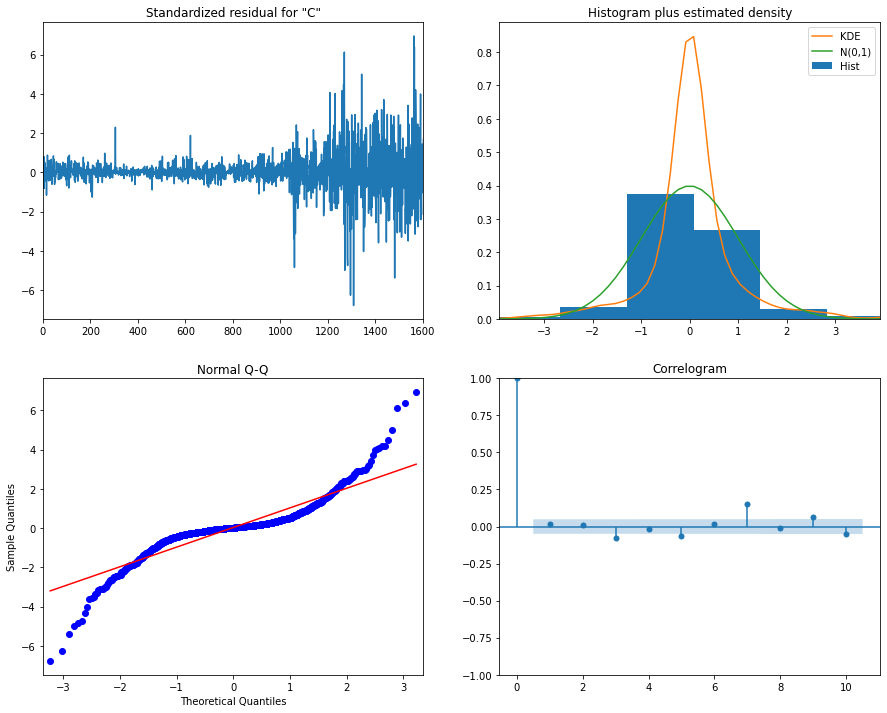

In [145]:
# Diagnosing the model residuals
SARIMAX_EDPR.plot_diagnostics(figsize = (15, 12))
plt.show()

##### Validating the Forecast

In [146]:
start = len(train_A)
end   = len(train_A) + len(test_A) - 1
predictions = SARIMAX_EDPR.predict(start = start, end = end, dynamic = False, typ = 'levels').rename('SARIMA Predictions')
print(predictions)

Date
2021-05-18    18.255287
2021-05-19    18.840317
2021-05-20    18.737009
2021-05-21    19.333725
2021-05-24    19.620296
                ...    
2022-04-19    23.083374
2022-04-20    22.746360
2022-04-21    23.044005
2022-04-22    22.732371
2022-04-25    22.540241
Name: SARIMA Predictions, Length: 243, dtype: float64


In [147]:
# Create a dataframe to store r2 score
R_SARIMAX_EDPR = pd.DataFrame({'r2_score': r2_score(test_A['Close'], predictions)}, index = [0])

# Add columns in the dataframe 'evaluation_results'
R_SARIMAX_EDPR['Model'] = 'SARIMA'
R_SARIMAX_EDPR.set_index(['Model'], inplace=True)
R_SARIMAX_EDPR['mean_absolute_error'] = mean_absolute_error(test_A['Close'], predictions)
R_SARIMAX_EDPR['mean_squared_error'] = mean_squared_error(test_A['Close'], predictions)
R_SARIMAX_EDPR['root_mean_squared_error'] = np.sqrt(mean_squared_error(test_A['Close'], predictions))
R_SARIMAX_EDPR['mean_absolute_percentage_error'] = np.mean(np.abs(predictions - test_A['Close'])
                                                               /np.abs(test_A['Close']))*100 
# Display the results
R_SARIMAX_EDPR

r2_score  mean_absolute_error  mean_squared_error  \
Model                                                       
SARIMA  0.920717             0.374021            0.228675   

        root_mean_squared_error  mean_absolute_percentage_error  
Model                                                            
SARIMA                   0.4782                        1.781822

#### B.- Vestas Wind Systems A/S (VWS.CO)

In [148]:
# order = (2, 1, 2) means 
# First 2 for auto regressive model, 1 for difference, and second 2 for moving average
# seasonal_order = (2, 1, 2, 12) means
# 12 additional parameter means number of observations per year or the period
SARIMAX_VWS = SARIMAX(VWS['Close'], order = (2, 1, 2), seasonal_order = (2, 1, 2, 12)).fit(dis = -1)

# Display the summary of the model
print(SARIMAX_VWS.summary())

                                     SARIMAX Results                                      
Dep. Variable:                              Close   No. Observations:                 1548
Model:             SARIMAX(2, 1, 2)x(2, 1, 2, 12)   Log Likelihood               -4430.345
Date:                            Tue, 26 Apr 2022   AIC                           8878.689
Time:                                    21:08:35   BIC                           8926.716
Sample:                                         0   HQIC                          8896.560
                                           - 1548                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.2568      0.054    -23.329      0.000      -1.362      -1.151
ar.L2         -0.8563      0.046   

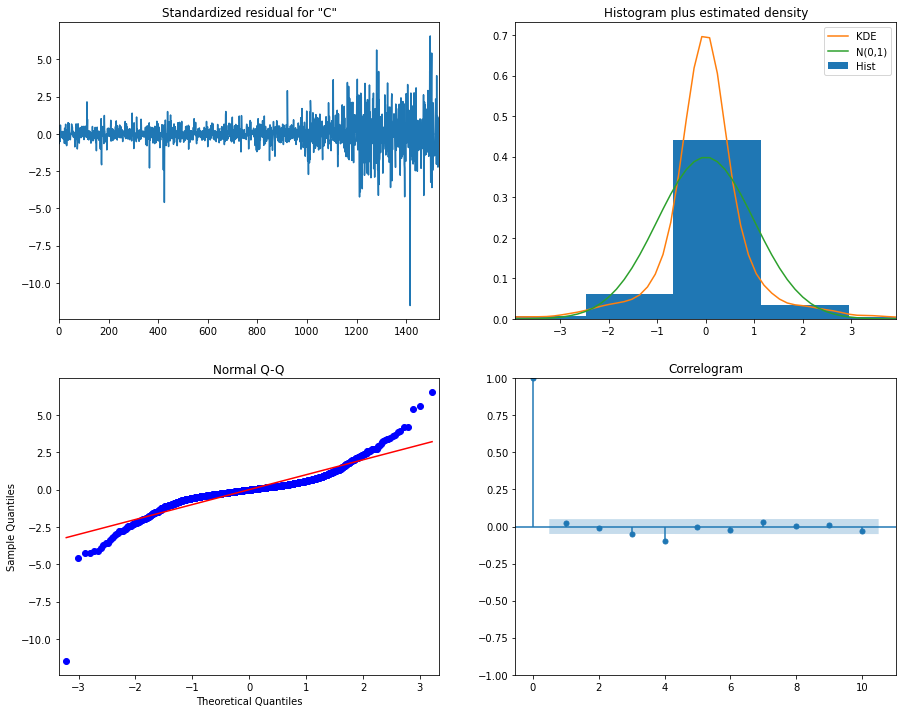

In [149]:
# Diagnosing the model residuals
SARIMAX_VWS.plot_diagnostics(figsize = (15, 12))
plt.show()

##### Validating the Forecast

In [150]:
start = len(train_B)
end   = len(train_B) + len(test_B) - 1
predictions = SARIMAX_VWS.predict(start = start, end = end, dynamic = False, typ = 'levels').rename('SARIMA Predictions')
print(predictions)

1341    252.219634
1342    247.007541
1343    245.051218
1344    249.856037
1345    254.677422
           ...    
1573    190.897877
1574    190.774748
1575    190.855608
1576    191.189577
1577    191.558250
Name: SARIMA Predictions, Length: 237, dtype: float64


https://stackoverflow.com/questions/38361526/fill-the-missing-date-values-in-a-pandas-dataframe-column

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

In [151]:
# Create a dataframe to store r2 score
R_SARIMAX_VWS= pd.DataFrame({'r2_score': r2_score(test_B['Close'], predictions)}, index = [0])

# Add columns in the dataframe 'evaluation_results'
R_SARIMAX_VWS['Model'] = 'SARIMA'
R_SARIMAX_VWS.set_index(['Model'], inplace=True)
R_SARIMAX_VWS['mean_absolute_error'] = mean_absolute_error(test_B['Close'], predictions)
R_SARIMAX_VWS['mean_squared_error'] = mean_squared_error(test_B['Close'], predictions)
R_SARIMAX_VWS['root_mean_squared_error'] = np.sqrt(mean_squared_error(test_B['Close'], predictions))
R_SARIMAX_VWS['mean_absolute_percentage_error'] = np.mean(np.abs(predictions - test_B['Close'])
                                                               /np.abs(test_B['Close']))*100 
# Display the results
R_SARIMAX_VWS

r2_score  mean_absolute_error  mean_squared_error  \
Model                                                       
SARIMA  0.153351            22.356468          728.221198   

        root_mean_squared_error  mean_absolute_percentage_error  
Model                                                            
SARIMA                26.985574                             NaN

### IV.4.-Keras

#### A.- EDP Renováveis (EDPR.LS) 

In [152]:
 """model = Sequential()
model.add(LSTM(units=50,return_sequences=True,input_shape=(train_A.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50,return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50,return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam',loss='mean_squared_error')
model.fit(train_A,train_A,epochs=100,batch_size=32)"""

"model = Sequential()\nmodel.add(LSTM(units=50,return_sequences=True,input_shape=(train_A.shape[1], 1)))\nmodel.add(Dropout(0.2))\nmodel.add(LSTM(units=50,return_sequences=True))\nmodel.add(Dropout(0.2))\nmodel.add(LSTM(units=50,return_sequences=True))\nmodel.add(Dropout(0.2))\nmodel.add(LSTM(units=50))\nmodel.add(Dropout(0.2))\nmodel.add(Dense(units=1))\nmodel.compile(optimizer='adam',loss='mean_squared_error')\nmodel.fit(train_A,train_A,epochs=100,batch_size=32)"

In [153]:
"""total = pd.concat((train_A['Close'], test_A['Close']), axis = 0)
inputs = total[len(total) - len(test_A) - 60:].values
inputs = inputs.reshape(-1,1)
X_test = []
for i in range(60, 76):
    X_test.append(inputs[i-60:i, 0])
    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
    predicted_stock_price = model.predict(X_test)
    predicted_stock_price = sc.inverse_transform(predicted_stock_price)"""

"total = pd.concat((train_A['Close'], test_A['Close']), axis = 0)\ninputs = total[len(total) - len(test_A) - 60:].values\ninputs = inputs.reshape(-1,1)\nX_test = []\nfor i in range(60, 76):\n    X_test.append(inputs[i-60:i, 0])\n    X_test = np.array(X_test)\n    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))\n    predicted_stock_price = model.predict(X_test)\n    predicted_stock_price = sc.inverse_transform(predicted_stock_price)"

https://www.thepythoncode.com/article/stock-price-prediction-in-python-using-tensorflow-2-and-keras

#### B.- Vestas Wind Systems A/S (VWS.CO)

### IV.5.-Facebook Prophet

#### A.- EDP Renováveis (EDPR.LS) 

#### B.- Vestas Wind Systems A/S (VWS.CO)

## Summary

In [154]:
Validation_EDPR= pd.concat([R_arma_EDPR,R_arima_EDPR,R_SARIMAX_EDPR])
Validation_EDPR

r2_score  mean_absolute_error  mean_squared_error  \
Model                                                       
ARMA    0.921171             0.372645            0.227365   
ARIMA   0.921248             0.372361            0.227145   
SARIMA  0.920717             0.374021            0.228675   

        root_mean_squared_error  mean_absolute_percentage_error  
Model                                                            
ARMA                   0.476828                        1.775954  
ARIMA                  0.476597                        1.774462  
SARIMA                 0.478200                        1.781822

In [155]:
Validation_VWS= pd.concat([R_arma_VWS,R_arima_VWS,R_SARIMAX_VWS])
Validation_VWS

r2_score  mean_absolute_error  mean_squared_error  \
Model                                                       
ARMA    0.143850            22.568890          736.392963   
ARIMA   0.150587            22.355080          730.598286   
SARIMA  0.153351            22.356468          728.221198   

        root_mean_squared_error  mean_absolute_percentage_error  
Model                                                            
ARMA                  27.136561                       10.413069  
ARIMA                 27.029582                       10.309233  
SARIMA                26.985574                             NaN

## Complementary Reading

Reference: Efstathopoulos g. (2020) Python for Finance, Part I: Yahoo & Google Finance API, pandas, and matplotlib 
Available at: URL <a href="https://www.learndatasci.com/tutorials/python-finance-part-yahoo-finance-api-pandas-matplotlib/ ">https://www.learndatasci.com/tutorials/python-finance-part-yahoo-finance-api-pandas-matplotlib/ </a>(Accessed 14 October 2021).  

Reference: Witham, J. (2020) The Imperative For A 24/7 Renewable Energy World, Forbes. 
Available at: URL <a href="https://pandas-datareader.readthedocs.io/en/latest/remote_data.html#remote-data-yahoo">https://pandas-datareader.readthedocs.io/en/latest/remote_data.html#remote-data-yahoo/ </a>(Accessed 14 October 2021).  

Reference: Norris, E. (2021) "Why Did My Stock's Ticker Change?", Investopedia. 
Available at: URL <a href="https://www.investopedia.com/ask/answers/why-did-my-stocks-ticker-change/">https://www.investopedia.com/ask/answers/why-did-my-stocks-ticker-change/ </a>(Accessed 14 October 2021).  

Reference: Mahgoub, A. (2021) "Stock Prediction using Regression Algorithm in Python", Medium. 
Available at: URL <a href="https://medium.com/codex/stock-predication-using-regression-algorithm-in-python-fb8b426453b9/">https://medium.com/codex/stock-predication-using-regression-algorithm-in-python-fb8b426453b9</a>(Accessed 25 Feb 2022). 

Reference: Prabhakaran, S. (2019) "Augmented Dickey Fuller Test (ADF Test) – Must Read Guide", Medium. 
Available at: URL <a href="https://www.machinelearningplus.com/time-series/augmented-dickey-fuller-test/#:~:text=Augmented%20Dickey%20Fuller%20test%20(ADF%20Test)%20is%20a%20common%20statistical,the%20stationary%20of%20a%20series.">https://www.machinelearningplus.com/time-series/augmented-dickey-fuller-test/#:~:text=Augmented%20Dickey%20Fuller%20test%20(ADF%20Test)%20is%20a%20common%20statistical,the%20stationary%20of%20a%20series.</a>

Reference: Masum, M. (2020) "Time Series Analysis: Identifying AR and MA using ACF and PACF Plots", Medium. 
Available at: URL <a href="https://towardsdatascience.com/identifying-ar-and-ma-terms-using-acf-and-pacf-plots-in-time-series-forecasting-ccb9fd073db8">https://towardsdatascience.com/identifying-ar-and-ma-terms-using-acf-and-pacf-plots-in-time-series-forecasting-ccb9fd073db8</a> (Accessed 21 March 2022).  

Reference: Zvornicanin E. (2021) "Choosing the best q and p from ACF and PACF plots in ARMA-type modeling", Baeldung. 
Available at: URL <a href="https://www.baeldung.com/cs/acf-pacf-plots-arma-modeling">https://www.baeldung.com/cs/acf-pacf-plots-arma-modeling</a> (Accessed 21 March 2022). 


Reference: Prabhakaran S. (2021) "ARIMA Model – Complete Guide to Time Series Forecasting in Python", Machinelearningplus. 
Available at: URL <a href="https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/">https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/</a> (Accessed 21 March 2022). 

Reference: Daitan (2019) "A Visual Guide to Time Series Decomposition Analysis", Betterprogramming 
Available at: URL <a href="https://betterprogramming.pub/a-visual-guide-to-time-series-decomposition-analysis-a1472bb9c930">https://betterprogramming.pub/a-visual-guide-to-time-series-decomposition-analysis-a1472bb9c930</a> (Accessed 14 April 2022).

Reference: Zach (2021) "Augmented Dickey-Fuller Test in Python (With Example)", Statology.org 
Available at: URL <a href="https://www.statology.org/dickey-fuller-test-python/">https://www.statology.org/dickey-fuller-test-python/</a> (Accessed 14 April 2022).

Reference: Shao, V.(2020) "Forecasting with a Time Series Model using Python: Part One", Bounteous
Available at: URL <a href="https://www.bounteous.com/insights/2020/09/15/forecasting-time-series-model-using-python-part-one/">https://www.bounteous.com/insights/2020/09/15/forecasting-time-series-model-using-python-part-one/</a> (Accessed 15 April 2022).


- https://github.com/lxu213/arima-forecasting/blob/master/arima-ts-forecasting.ipynb

-  https://pierpaolo28.github.io/blog/blog5/